In [201]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [202]:
piece = 'Salon'
id = 6560

In [203]:
ref = cv2.imread(f'Images/{piece}/Reference.JPG')
image = cv2.imread(f'Images/{piece}/IMG_{id}.JPG')

In [204]:
def get_mask():
    mask = np.zeros_like(image)
    if piece == 'Chambre':
        ROI= np.array([
            [3176, 792],
            [5544, 2172],
            [3584, 3912],
            [1287, 2136]
        ], np.int32)
    elif piece == 'Cuisine':
        ROI = np.array([
            [1100, 3999],
            [2000, 2000],
            [3600, 2000],
            [4500, 3999]
        ], np.int32)
    elif piece == 'Salon':
        ROI = np.array([
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0]
        ], np.int32)
    else:
        raise ValueError('@param piece must be one of the following: Chambre, Cuisine, Salon')
    
    cv2.fillPoly(mask, [ROI], (255, 255, 255))
    return mask

In [205]:
ref = cv2.bitwise_and(ref, get_mask())
image = cv2.bitwise_and(image, get_mask())

In [206]:
ref_LAB = cv2.cvtColor(ref, cv2.COLOR_BGR2LAB)
ref_HSV = cv2.cvtColor(ref, cv2.COLOR_BGR2HSV)
image_LAB = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
image_HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

In [207]:
ref_L, ref_A, ref_B = cv2.split(ref_LAB)
ref_H, ref_S, ref_V = cv2.split(ref_HSV)
image_L, image_A, image_B = cv2.split(image_LAB)
image_H, image_S, image_V = cv2.split(image_HSV)

In [208]:
diff_L = cv2.absdiff(ref_L, image_L)
diff_A = cv2.absdiff(ref_A, image_A)
diff_B = cv2.absdiff(ref_B, image_B)
diff_H = cv2.absdiff(ref_H, image_H)
diff_S = cv2.absdiff(ref_S, image_S)
diff_V = cv2.absdiff(ref_V, image_V)

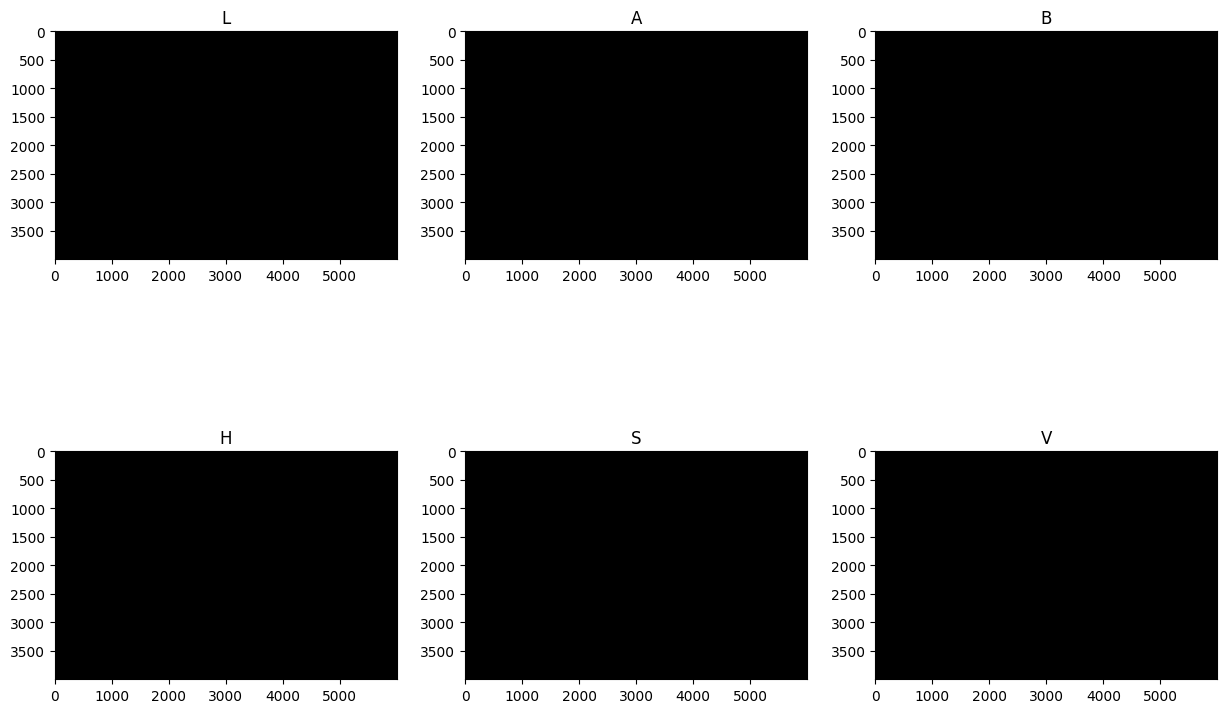

In [209]:
# plot the difference images in a grid with 2 rows and 3 columns
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].imshow(diff_L, cmap='gray')
ax[0, 0].set_title('L')
ax[0, 1].imshow(diff_A, cmap='gray')
ax[0, 1].set_title('A')
ax[0, 2].imshow(diff_B, cmap='gray')
ax[0, 2].set_title('B')
ax[1, 0].imshow(diff_H, cmap='gray')
ax[1, 0].set_title('H')
ax[1, 1].imshow(diff_S, cmap='gray')
ax[1, 1].set_title('S')
ax[1, 2].imshow(diff_V, cmap='gray')
ax[1, 2].set_title('V')

fig.savefig(f'diffs/{piece}/diff_IMG_{id}.png')